In [1]:
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import tensorflow_probability.substrates.jax as tfp

2023-03-01 05:57:23.420303: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndmap/lib/:
2023-03-01 05:57:27.659090: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndmap/lib/:
2023-03-01 05:57:27.659991: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/kndmap/lib/:
2023-03-01 05:57:27.660006: W t

In [2]:
tfd = tfp.distributions
rng = jax.random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
new_object_df = pd.read_csv("mcmc_dataset.csv", index_col=False)

In [4]:
# first select area of expected signal... -60 to +60 days
new_object_df[(new_object_df["time"].values>-30) & (new_object_df["time"].values<30)]

,Unnamed: 0,SNID,time,flux,fluxerr,object_index,band_index,norm_factor
0,0,5081715,-1.4000,1.246278,0.287578,0,1,265.440584
1,1,5081715,0.0000,1.000000,0.249833,0,0,265.440584
2,2,6596653,-1.0000,0.602328,0.143789,1,1,494.681320
3,3,6596653,0.0000,0.357976,0.095791,1,1,494.681320
4,4,6596653,0.0000,1.000000,0.177067,1,0,494.681320
...,...,...,...,...,...,...,...,...
40389,40389,93908538,19.9978,0.556569,0.138986,999,0,409.059418
40390,40390,93908538,20.0207,0.017564,0.148990,999,1,409.059418
40391,40391,93908538,23.0186,0.262706,0.118521,999,1,409.059418
40392,40392,93908538,25.9978,0.052418,0.104422,999,1,409.059418


In [5]:
new_object_df=new_object_df[:1000]

NOTE that the flux values are normalized. 
To get the actual values, multiply flux and fluxerr columns with norm_factor

In [6]:
#define the parametric function of the lightcurve
def parametric_fn(t0, t_rise, t_fall, amplitude, x_range):
    
    time_dif = x_range - t0
    numerator = jnp.exp(-time_dif/t_fall)
    denominator = 1 + jnp.exp(-time_dif/t_rise)
    predicted_lc = amplitude * ( numerator/ denominator )
    return predicted_lc

In [7]:
# Disdistribution with interband correlations
# TODO: find the actual correlation between the bands.

def jd_model(index, x_range):

    assert index.shape[0] == x_range.shape[0]

    num_channel = np.unique(index[:, 1]).shape[0]
    num_event = np.unique(index[:, 0]).shape[0]

    @tfd.JointDistributionCoroutineAutoBatched
    def current_event():
        # define priors
        
        t0_hyper = yield tfd.Sample(tfd.Uniform(-2, 2), (num_event), name="t0_hyper")
        t0 = yield tfd.Sample(tfd.Uniform(t0_hyper-1, t0_hyper+1), (num_channel), name="t0")

        t_rise_hyper_prior = yield tfd.Sample(tfd.Uniform(.25, 5), (num_event), name="t_rise_hyper")
        t_rise = yield tfd.Sample(tfd.Uniform(t_rise_hyper_prior - t_rise_hyper_prior/4, t_rise_hyper_prior + t_rise_hyper_prior/4), (num_channel), name="t_rise")

        t_fall_hyper_prior = yield tfd.Sample(tfd.Uniform(.25, 5), (num_event), name="t_fall_hyper_prior")
        t_fall_= yield tfd.Sample(tfd.Uniform(t_fall_hyper_prior - t_fall_hyper_prior/4, t_fall_hyper_prior + t_fall_hyper_prior/4), (num_channel), name="t_fall_")
        
        t_fall = t_rise + t_fall_

        amplitude = yield tfd.Sample(tfd.Gamma(10, 5), (num_event, num_channel), name="amp")
    
        # evaluate the predictions
        prediction = parametric_fn(
            t0[index[:, 0], index[:, 1]],
            t_rise[index[:, 0], index[:, 1]],
            t_fall[index[:, 0], index[:, 1]],
            amplitude[index[:, 0], index[:, 1]], 
            x_range,
        )

        # Likelihood
        sigma = yield tfd.Sample(tfd.Gamma(1, 1), len(index), name="sigma")
        yield tfd.Normal(prediction, sigma, name="obs")

    return current_event

In [8]:
index = np.zeros((len(new_object_df), 2), dtype=np.int32)

index[:, 0] = new_object_df["object_index"]
index[:, 1] = new_object_df["band_index"]

x_range = np.asarray(new_object_df["time"])

observed_value = jnp.array(np.asarray(new_object_df["flux"]), dtype=jnp.float32)
observed_sigma = jnp.array(np.asarray(new_object_df["fluxerr"]), dtype=jnp.float32)

jd = jd_model(index, x_range)


In [9]:
jd

<tfp.distributions.JointDistributionCoroutineAutoBatched 'JointDistributionCoroutineAutoBatched' batch_shape=[] event_shape=StructTuple(
  t0_hyper=[212],
  t0=[212, 2],
  t_rise_hyper=[212],
  t_rise=[212, 2],
  t_fall_hyper_prior=[212],
  t_fall_=[212, 2],
  amp=[212, 2],
  sigma=[1000],
  obs=[1000]
) dtype=StructTuple(
  t0_hyper=float32,
  t0=float32,
  t_rise_hyper=float32,
  t_rise=float32,
  t_fall_hyper_prior=float32,
  t_fall_=float32,
  amp=float32,
  sigma=float32,
  obs=float32
)>

In [10]:
# Run the mcmc

run_mcmc = jax.jit(
    lambda seed: tfp.experimental.mcmc.windowed_adaptive_nuts(
        100, 
        jd, 
        n_chains=4, 
        num_adaptation_steps=100, 
        seed=seed,
        sigma=observed_sigma, 
        obs=observed_value,
    )
)

rng, sample_rng = jax.random.split(rng, 2)
mcmc_samples, sampler_stats = run_mcmc(sample_rng)

In [11]:
mcmc_samples.t0.shape

(100, 4, 212, 2)

In [12]:
mcmc_samples.t0[10, 0, 13]

Array([-1.1800318, -2.8433013], dtype=float32)

In [13]:
import matplotlib.pyplot as plt

In [14]:
# Plot the posterior light curve reconstructions

0


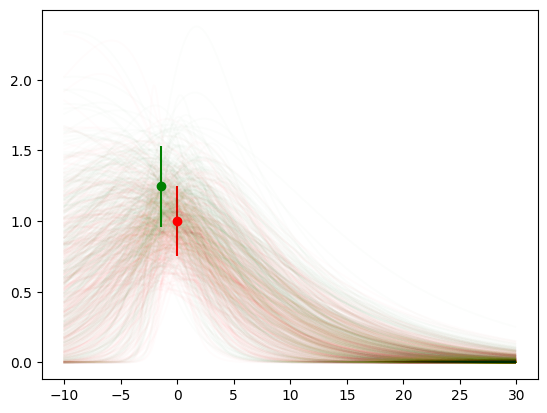

1


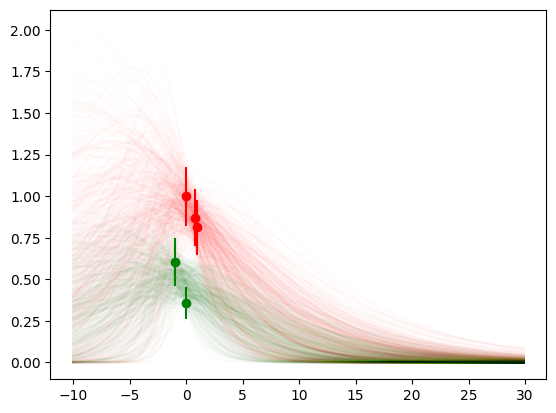

2


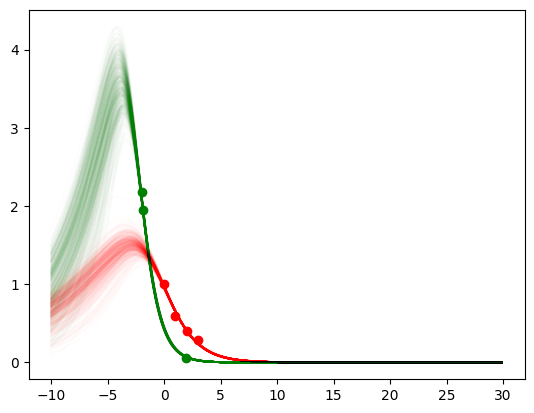

3


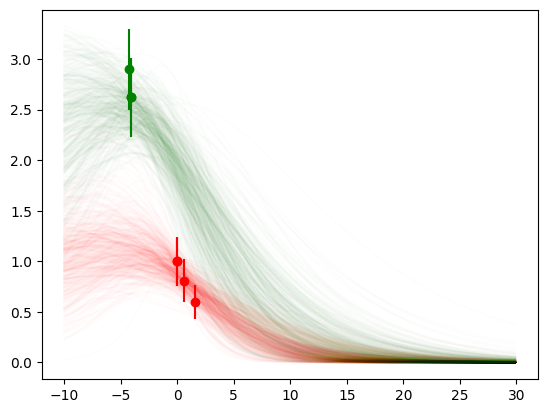

4


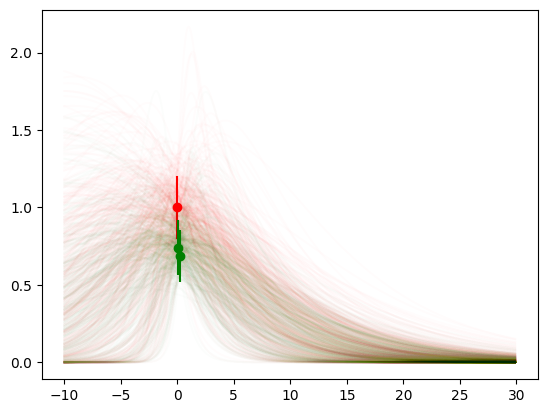

5


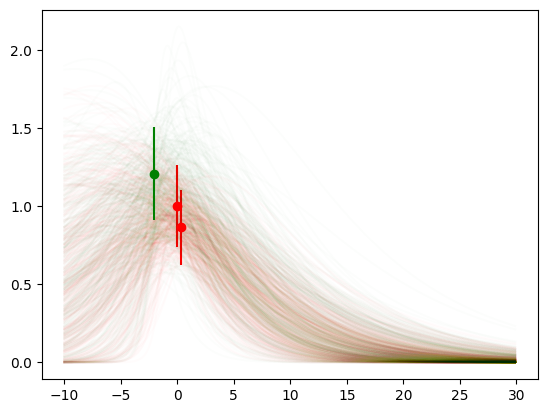

6


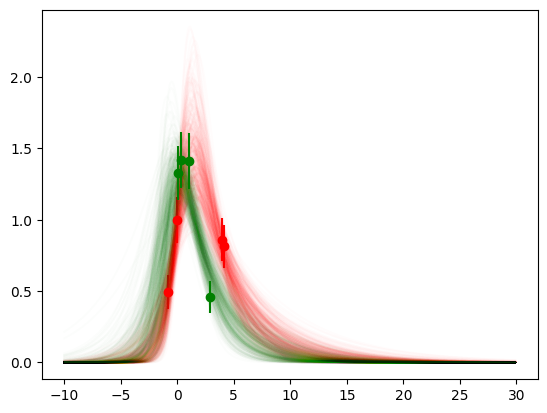

7


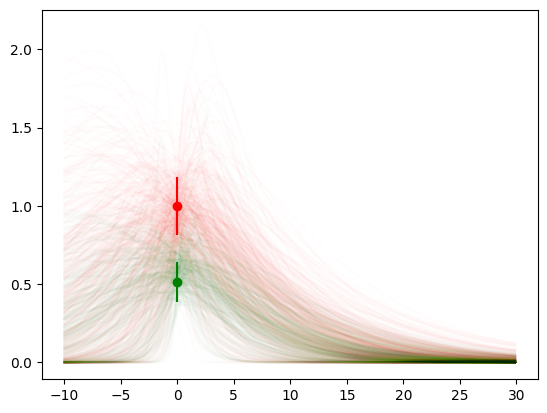

8


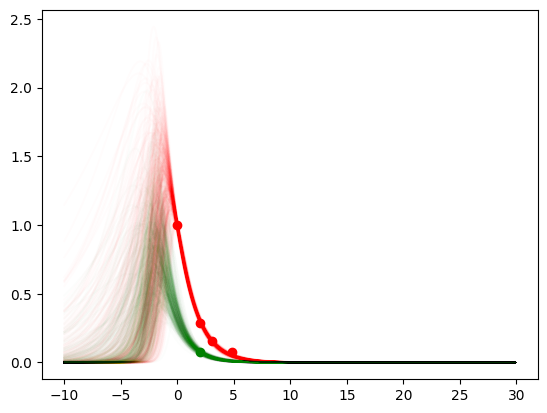

9


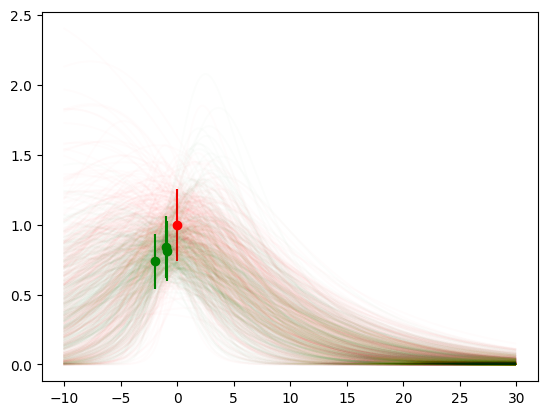

10


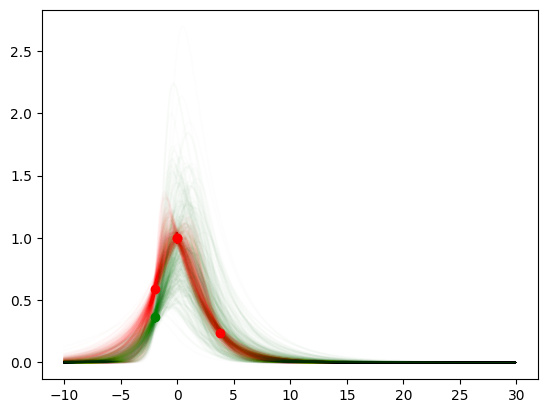

11


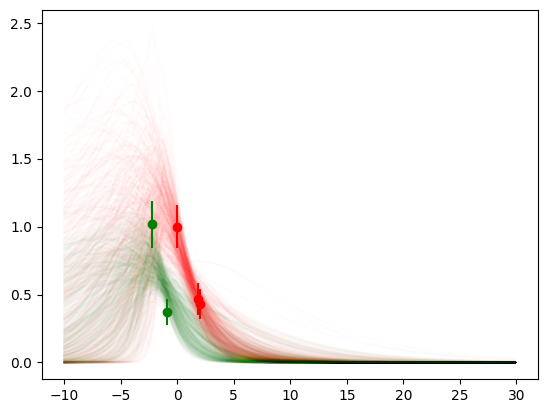

12


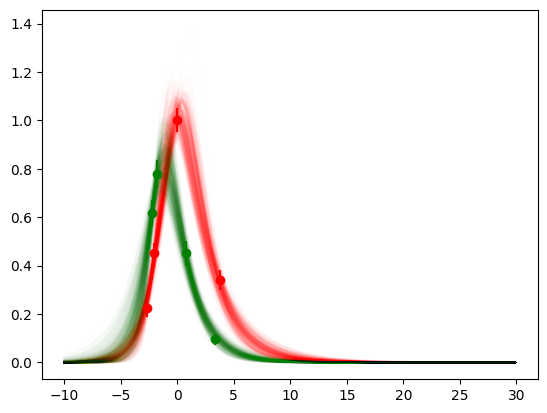

13


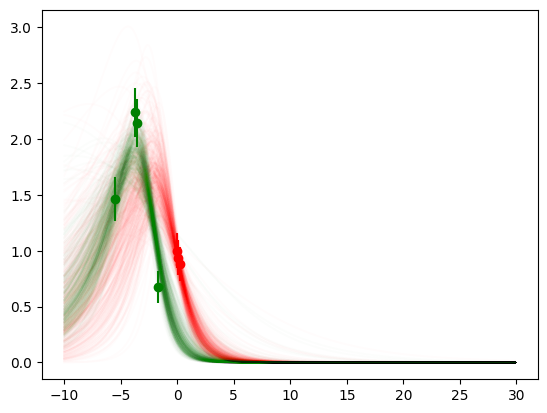

14


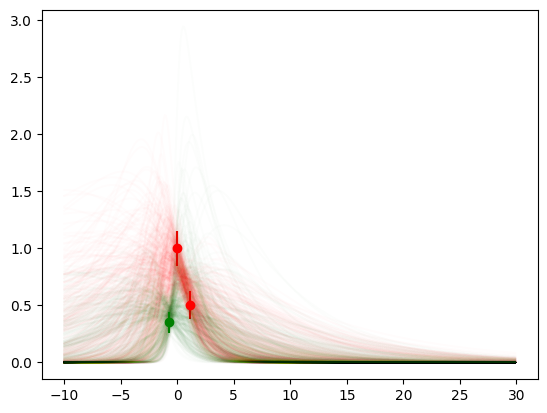

15


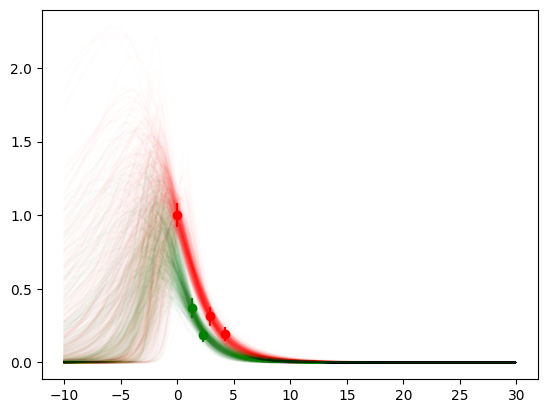

16


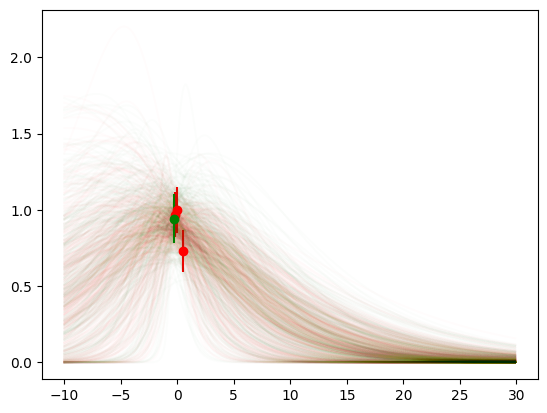

17


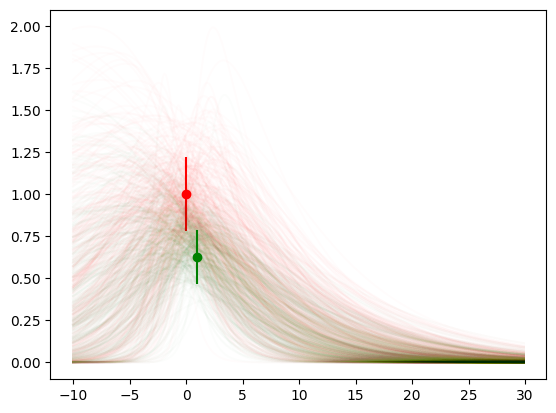

18


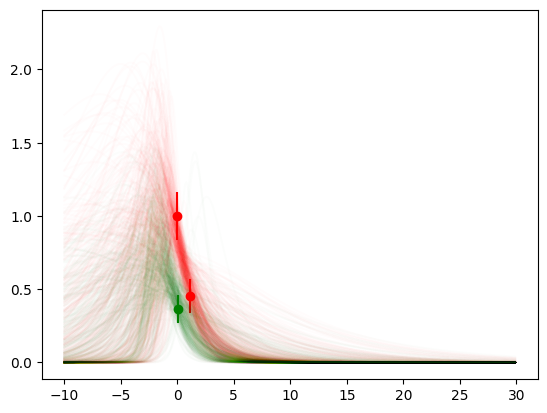

19


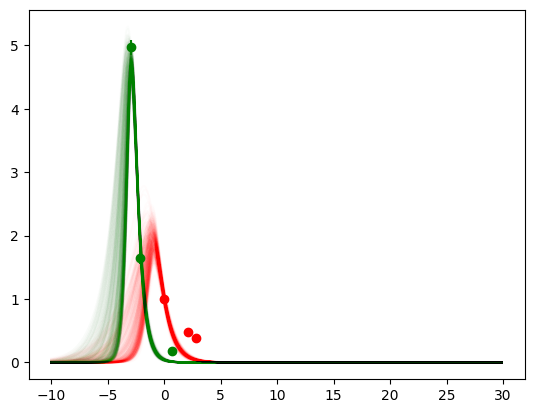

20


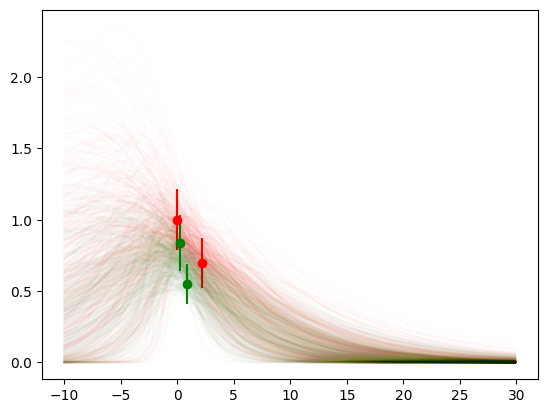

In [15]:
colors = ['r', 'g']
for event_num in range(len(index)):
    print(event_num)
    plt.figure()
    object_df = new_object_df[new_object_df['object_index']==event_num]
    for band in range(2):
        for sample_no in range(100):

            for chain_num in range(4):
                t0 = mcmc_samples.t0[sample_no, chain_num, event_num, band]
                t_rise = mcmc_samples.t_rise[sample_no, chain_num, event_num, band]
                t_fall_ = mcmc_samples.t_fall_[sample_no, chain_num, event_num, band]
                t_fall = t_fall_ + t_rise
                amp = mcmc_samples.amp[sample_no, chain_num, event_num, band]

                predictions = parametric_fn(t0, t_rise, t_fall, amp, np.arange(-10,30, .1))
                plt.plot(np.arange(-10,30, .1), predictions, alpha=.01, color=colors[band])

        band_df = object_df[object_df['band_index']==band]
        plt.errorbar(band_df["time"], band_df["flux"], yerr=band_df["fluxerr"], fmt="o", color=colors[band])

    if event_num==20:
        break
    plt.show()